In [2]:
# librerías a usar
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Transmisor

In [3]:
Fs = 100  # 100[Hz] sampling frequency [samples/sec]
duracion = 10  # [s]
sps = 8  # [samples/symbol] cantidad de samples por simbolo
N = int(Fs*duracion)  # [samples] cantidad de samples que tomamos en total
Nsym = int(N/sps)  # [symbols] cantidad de simbolos que tomamos en total

print("Cantidad de samples: ", N, "\nCantidad de simbolos: ", Nsym)


Cantidad de samples:  1000 
Cantidad de simbolos:  125


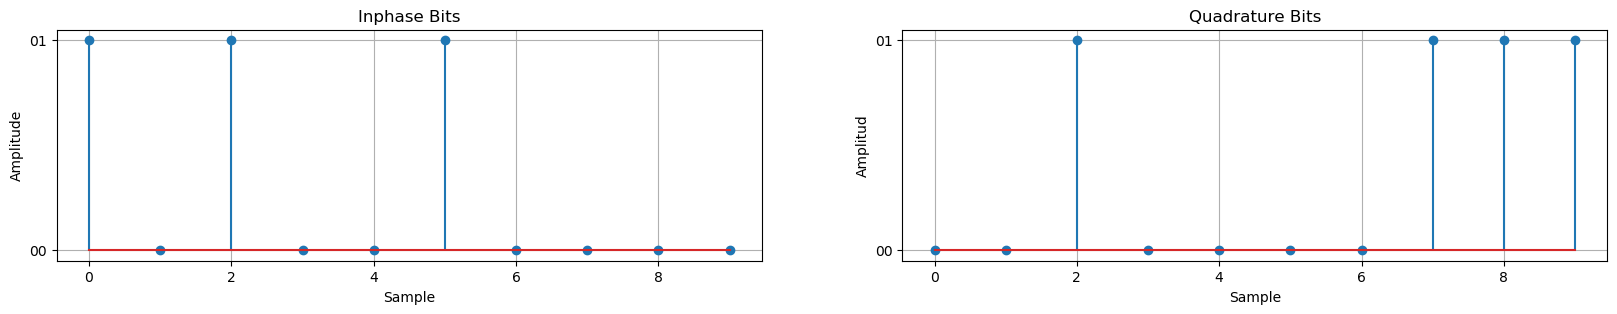

In [4]:
from matplotlib.ticker import StrMethodFormatter

bits = np.random.randint(0, 2, N)  # [0,1] bits aleatorios

i_bits = bits[0::2]  # bits pares
q_bits = bits[1::2]  # bits impares

fig, (ax_i, ax_q) = plt.subplots(1, 2, figsize=(20, 3))
ax_i.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_i.yaxis.set_ticks(np.arange(0, 11, 1))
ax_i.set_title("Inphase Bits")
ax_i.grid(True)
ax_i.set_xlabel("Sample")
ax_i.set_ylabel("Amplitude")
ax_i.stem(i_bits[0:10], use_line_collection=True)

ax_q.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_q.yaxis.set_ticks(np.arange(0, 11, 1))
ax_q.set_title("Quadrature Bits")
ax_q.set_xlabel("Sample")
ax_q.set_ylabel("Amplitud")
ax_q.stem(q_bits[0:10], use_line_collection=True)
ax_q.grid(True)
plt.show()


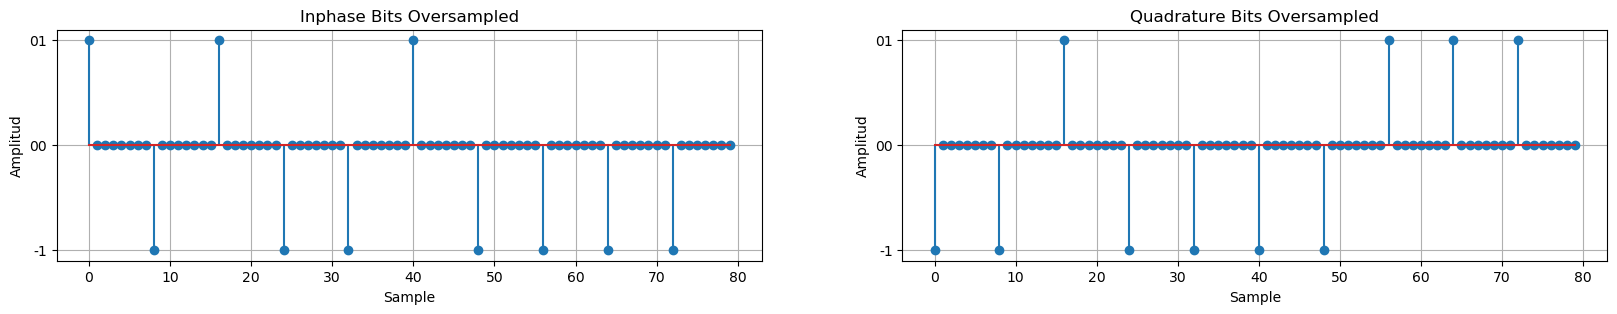

In [5]:

osample_i = np.array([])
for index, bit in enumerate(i_bits):
    pulse = np.zeros(sps)  # "relleno" un array de 8 bits con 0
    pulse[0] = bit*2 - 1
    # concateno el array de 8 bits con el array de bits
    osample_i = np.concatenate((osample_i, pulse))

osample_q = np.array([])
for bit in q_bits:
    pulse = np.zeros(sps)  # "relleno" un array de 8 bits con 0
    pulse[0] = bit*2 - 1
    # concateno el array de 8 bits con el array de bits
    osample_q = np.concatenate((osample_q, pulse))

fig, (ax_i, ax_q) = plt.subplots(1, 2, figsize=(20, 3))
ax_i.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_i.yaxis.set_ticks(np.arange(-11, 11, 1))
ax_i.set_title("Inphase Bits Oversampled")
ax_i.grid(True)
ax_i.set_xlabel("Sample")
ax_i.set_ylabel("Amplitud")
ax_i.stem(osample_i[0:80], use_line_collection=True)

ax_q.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_q.yaxis.set_ticks(np.arange(-11, 11, 1))
ax_q.set_title("Quadrature Bits Oversampled")
ax_q.set_xlabel("Sample")
ax_q.set_ylabel("Amplitud")
ax_q.stem(osample_q[0:80], use_line_collection=True)
ax_q.grid(True)
plt.show()


# Root Raised-Cosine Filter

Es un filtro pasa bajo muy utilizado para limitar el ancho de banda que nuestra señanl va a ocupar. También tiene la propiedad de valer 0 en intervalos de T. Se implementa en el transmisor y en el receptor.

### Factor de Roll-Off
El parámetro $\beta$ toma valores entre 0 y 1 y determina cuán rapido, en el dominio del tiempo, el filtro decae a 0. Mientras más bajo sea el roll-off, más compacta es nuestra señal en frecuencia.

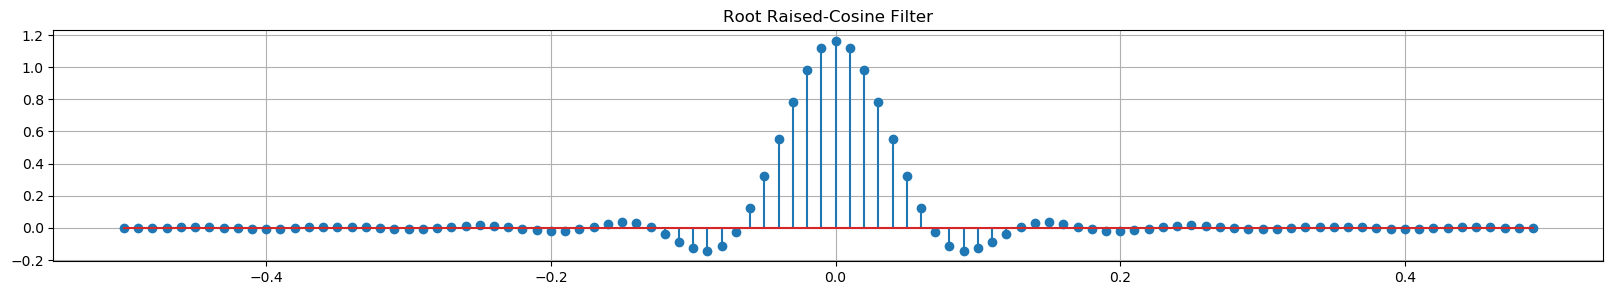

In [6]:
from commpy.filters import rrcosfilter

length = 100
beta = 0.6
Tsym = sps/Fs

time, filter_response = rrcosfilter(length, beta, Tsym, Fs)
# time:  Array containing the time indices, in seconds, for the impulse response.
# filter_response:  Array containing the impulse response values.

plt.figure(figsize=(20, 3))
plt.stem(time, filter_response, use_line_collection=True)
plt.title("Root Raised-Cosine Filter")
plt.grid(True)
plt.show()


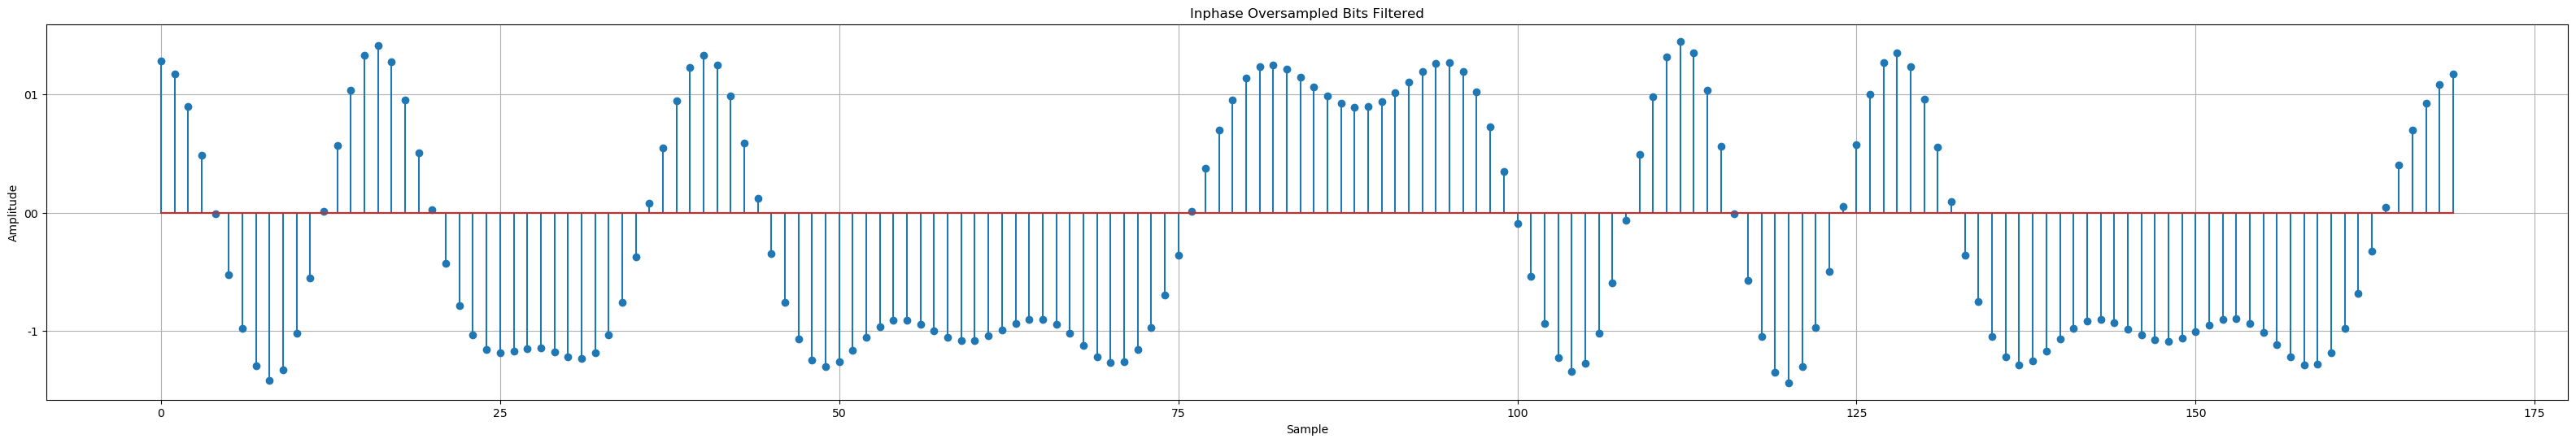

In [7]:
i_filtered = np.convolve(osample_i, filter_response)
delay = int(length/2)
i_filtered = i_filtered[delay:]  # elimino el comportamiento transitorio

fig, ax = plt.subplots(figsize=(40, 6))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax.yaxis.set_ticks(np.arange(-11, 11, 1))
ax.set_title("Inphase Oversampled Bits Filtered")
ax.grid(True)
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")
ax.stem(i_filtered[0:170], use_line_collection=True)
plt.show()


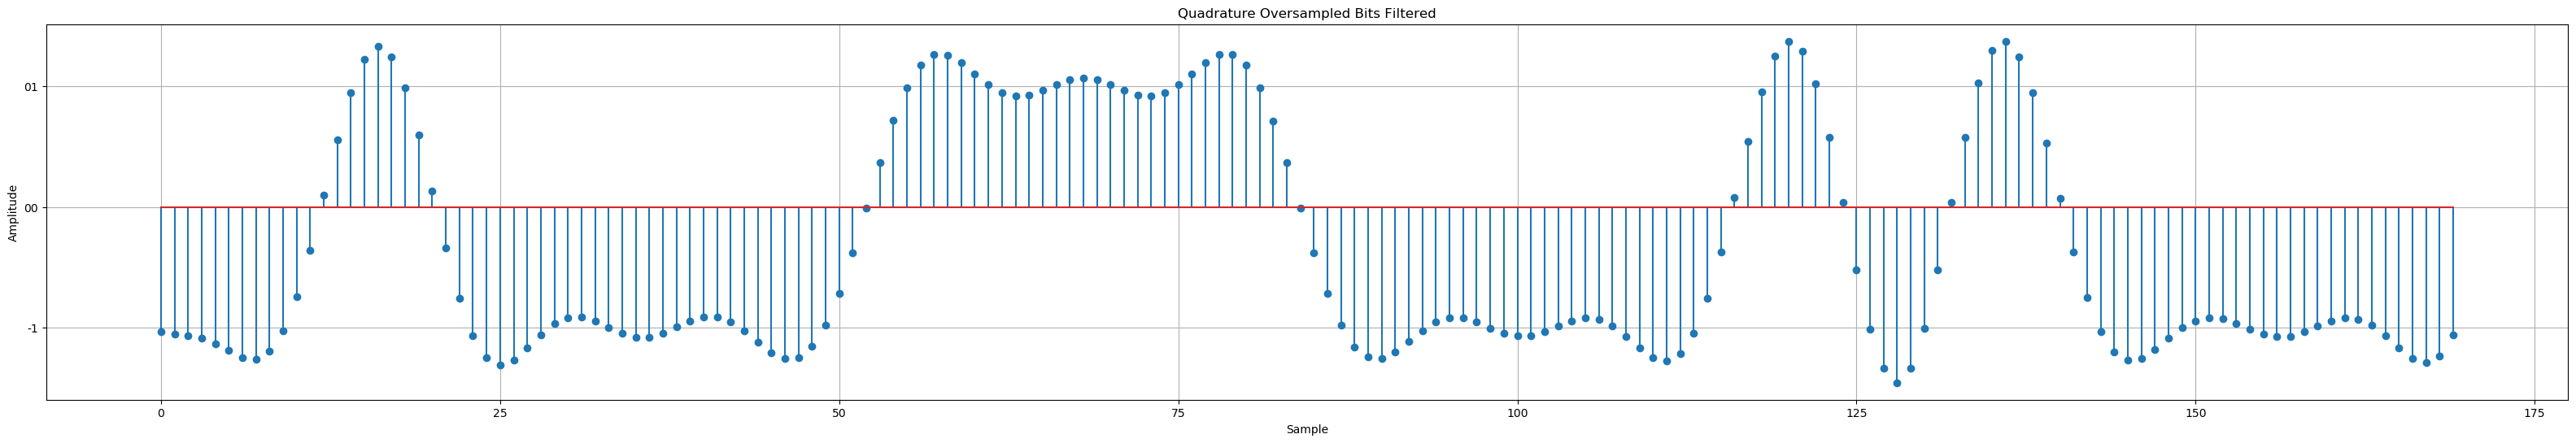

In [8]:
q_filtered = np.convolve(osample_q, filter_response)
q_filtered = q_filtered[delay:]

fig, ax = plt.subplots(figsize=(40, 6))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax.yaxis.set_ticks(np.arange(-11, 11, 1))
ax.set_title("Quadrature Oversampled Bits Filtered")
ax.grid(True)
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitude")
ax.stem(q_filtered[0:170], use_line_collection=True)
plt.show()


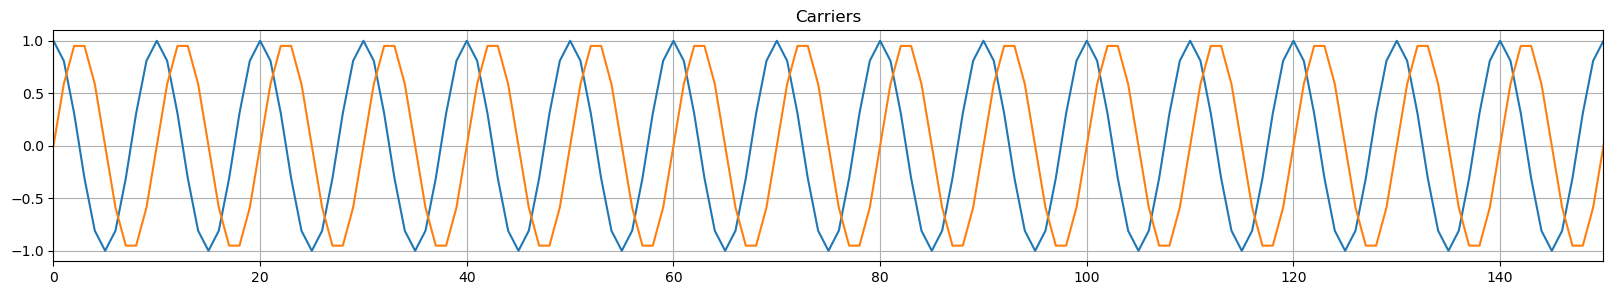

In [9]:
Fc = 1e6  # [Hz] carrier frequency
fsc = 10*Fc
tsc = 1/fsc
t = np.arange(len(i_filtered))

#t = np.linspace(0, duracion, int(Fs)*duracion, endpoint=False)
#frequencies = t / int(Fc)

i_carrier = np.cos((2*np.pi)*Fc*tsc*t)
q_carrier = np.sin((2*np.pi)*Fc*tsc*t)


plt.figure(figsize=(20, 3))
plt.plot(t, i_carrier, q_carrier)
plt.xlim(0, 150)
plt.title("Carriers")
plt.grid(True)
plt.show()


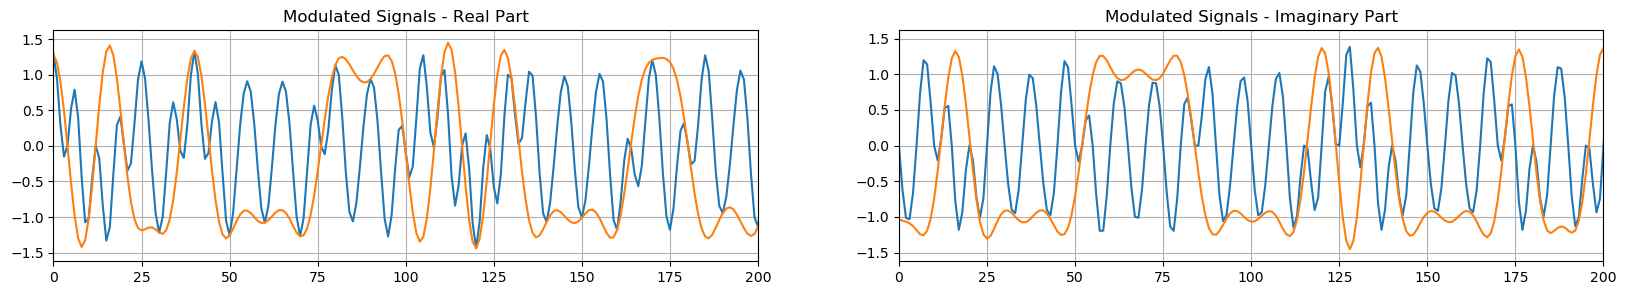

In [10]:
q_modulated = q_filtered * q_carrier
i_modulated = i_filtered * i_carrier

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(t, i_modulated, i_filtered)
plt.xlim(0, 200)
plt.title("Modulated Signals - Real Part")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(t, q_modulated, q_filtered)
plt.xlim(0, 200)
plt.title("Modulated Signals - Imaginary Part")
plt.grid(True)
plt.show()


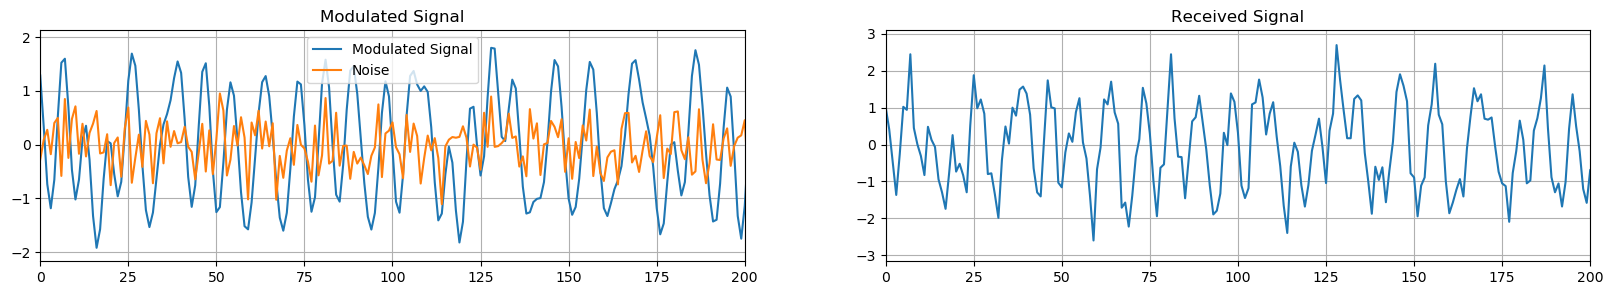

In [63]:
signal_modulated = i_modulated + q_modulated
#noise = np.random.randn(len(signal_modulated))
noise = np.random.normal(0, 0.4, len(signal_modulated))
signal_noise = signal_modulated + noise
t = np.arange(len(signal_modulated))

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(t, signal_modulated, label="Modulated Signal")
plt.plot(t, noise, label="Noise")
plt.xlim(0, 200)
plt.title("Modulated Signal")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t, signal_noise, label="Modulated Signal + Noise")
plt.xlim(0, 200)
plt.title("Received Signal")
plt.grid(True)
plt.show()


# Receptor

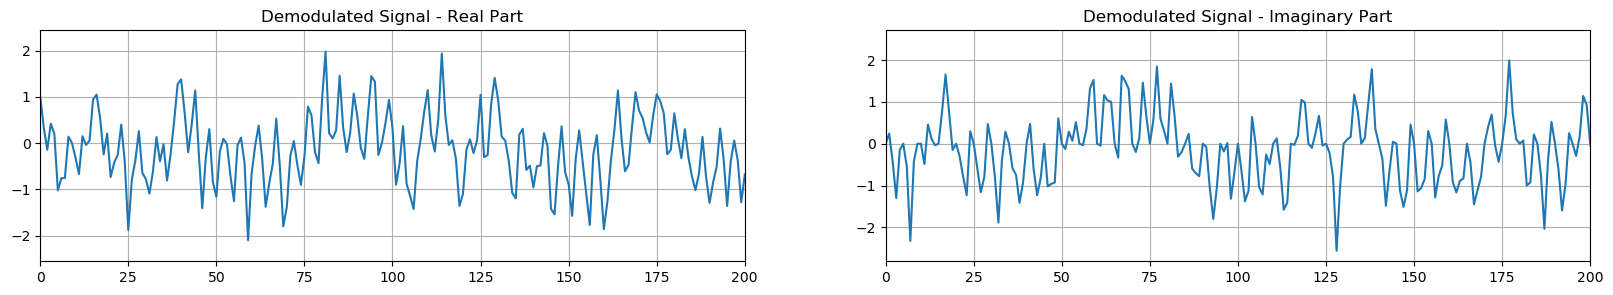

In [64]:
demodulated_i = signal_noise * i_carrier
demodulated_q = signal_noise * q_carrier

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(t, demodulated_i)
plt.xlim(0, 200)
#plt.ylim(-2, 2)
plt.title("Demodulated Signal - Real Part")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(t, demodulated_q)
plt.xlim(0, 200)
#plt.ylim(-2, 2)
plt.title("Demodulated Signal - Imaginary Part")
plt.grid(True)
plt.show()


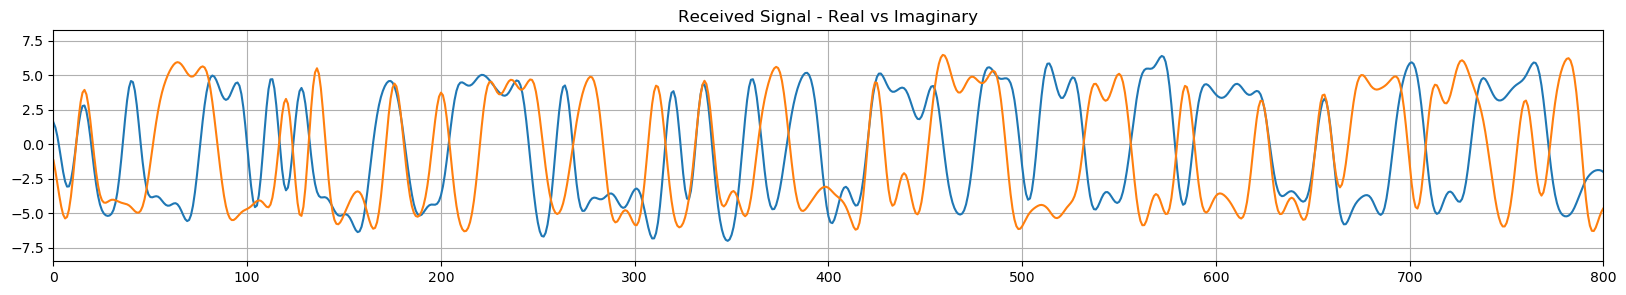

In [65]:
q_filtered_r = np.convolve(demodulated_q, filter_response)
q_filtered_r = q_filtered_r[delay:]
i_filtered_r = np.convolve(demodulated_i, filter_response)
i_filtered_r = i_filtered_r[delay:]
t = np.arange(len(i_filtered_r))

plt.figure(figsize=(20, 3))
plt.plot(t, i_filtered_r, q_filtered_r)
plt.xlim(0, 800)
plt.title("Received Signal - Real vs Imaginary")
plt.grid(True)
plt.show()


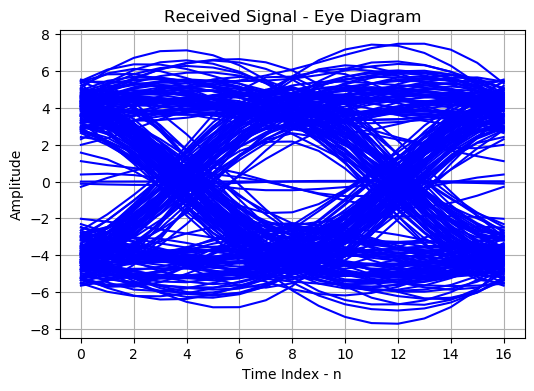

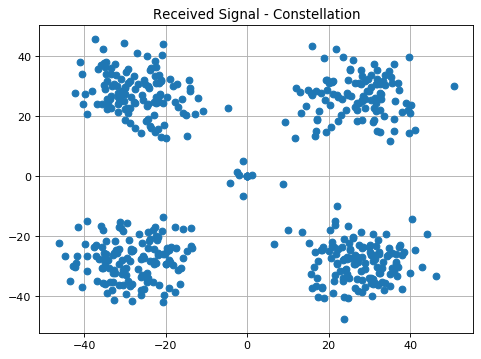

In [75]:
# --------------------- Diagrama de Ojo ---------------------#
from sk_dsp_comm import digitalcom as dc
length_eye = sps*2      # display length in samples (usually two symbols)
start = 0               # start index

dc.eye_plot(i_filtered_r, length_eye, start)
plt.title("Received Signal - Eye Diagram")
#dc.eye_plot(q_filtered_r, length_eye, start)
#plt.title("Diagrama de ojo - Señal Imaginaria")
plt.show()

# ----------------------  Constelación ---------------------#

i_sampled = np.convolve(i_filtered_r, np.ones(sps))
i_sampled = i_sampled[int(sps/2):]
i_sampled = i_sampled[sps::sps]
q_sampled = np.convolve(q_filtered_r, np.ones(sps))
q_sampled = q_sampled[int(sps/2):]
q_sampled = q_sampled[sps::sps]

plt.figure(figsize=(7, 5), dpi=80)
plt.plot(i_sampled, q_sampled, 'o')
plt.title("Received Signal - Constellation")
plt.grid(True)
plt.show()


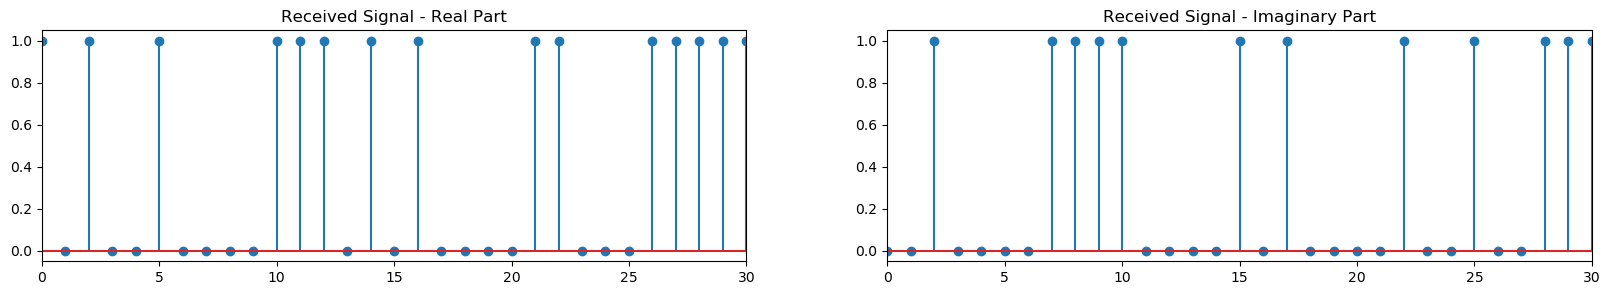

In [76]:
i_estimated = np.array([])
for bit in range(0, len(i_filtered_r), sps):  # range(start, stop, step)
    if i_filtered_r[bit] > 0.5:
        i_estimated = np.concatenate((i_estimated, [1]))
    else:
        i_estimated = np.concatenate((i_estimated, [0]))

q_estimated = np.array([])
for bit in range(0, len(q_filtered_r), sps):  # range(start, stop, step)
    if q_filtered_r[bit] > 0.5:
        q_estimated = np.concatenate((q_estimated, [1]))
    else:
        q_estimated = np.concatenate((q_estimated, [0]))

n = np.arange(len(i_estimated))
#print(q_filtered_r[0:100], q_estimated[0:100])

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.stem(i_estimated, use_line_collection=True)
plt.xlim(0, 30)
plt.title("Received Signal - Real Part")
plt.subplot(1, 2, 2)
plt.stem(q_estimated, use_line_collection=True)
plt.xlim(0, 30)
plt.title("Received Signal - Imaginary Part")
plt.show()


In [77]:
q_error = 0
i_error = 0
#print("Bits entrada: ", i_bits, "\nBits estimados: ", i_sampled)
for bit in range(0, len(i_bits)):
    if i_bits[bit] != i_estimated[bit]:
        i_error = i_error + 1

for bit in range(0, len(q_bits)):
    if q_bits[bit] != q_estimated[bit]:
        q_error = q_error + 1

BER = ((i_error + q_error) / (len(i_bits) + len(q_bits)))*100

print("Transmitted bits: ", (len(i_bits) + len(q_bits)),
      "\nError bits: ", i_error + q_error, "\nBER: {:.2f}%".format(BER))


Transmitted bits:  1000 
Error bits:  0 
BER: 0.00%
